In [2]:
# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/user/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('linear_regression_adv_lche329_ridge_9to1_VZ').getOrCreate()

# If you're getting an error with numpy, please type 'sudo pip install numpy --user' into the EC2 console.
from pyspark.ml.regression import LinearRegression

In [3]:
df = spark.read.load('./Sales_data/sales_en.csv',format='csv',header='true',inferSchema = True)

In [4]:
# Print the schema of the DataFrame. You can see potential features as well as the predictor.
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Product Name: string (nullable = true)
 |-- Unit: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Sales Representative: string (nullable = true)
 |-- Hospital Name: string (nullable = true)
 |-- Hospital Attribute: string (nullable = true)
 |-- Hospital Code: string (nullable = true)
 |-- Purchasing Price: double (nullable = true)
 |-- Selling Price: double (nullable = true)
 |-- IMF: string (nullable = true)
 |-- Hospital Class: string (nullable = true)
 |-- Department: string (nullable = true)
 |-- Client Name: string (nullable = true)
 |-- Sales Volume: double (nullable = true)
 |-- Profits: double (nullable = true)
 |-- Satisfaction: string (nullable = true)



In [5]:
df.head()

Row(ID=1, Year=2016, Product Name='Corbrin Capsule', Unit='Dept. 2', Region='Wuhan', Sales Representative='Xiongting', Hospital Name='Huazhongkejidaxuetongjiyixueyuanfushuxieheyiyuan', Hospital Attribute='Ministerial hospital', Hospital Code='ADXH', Purchasing Price=47.14, Selling Price=63.14, IMF='1571181790', Hospital Class='Third Class', Department='Shenneike', Client Name='Denganguo', Sales Volume=236.0, Profits=3776.0, Satisfaction='Y')

In [5]:
# A simple for loop allows us to make it even clearer. 
for item in df.head():
    print(item)

1
2016
Corbrin Capsule
Dept. 2
Wuhan
Xiongting
Huazhongkejidaxuetongjiyixueyuanfushuxieheyiyuan
Ministerial hospital
ADXH
47.14
63.14
1571181790
Third Class
Shenneike
Denganguo
236.0
3776.0
Y


In [6]:
# Import VectorAssembler and Vectors
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [7]:
# The input columns are the feature column names, and the output column is what you'd like the new column to be named. 
assembler = VectorAssembler(
    inputCols=["Sales Representative", "Hospital Attribute", 
               "Selling Price","Hospital Class","Department","Sales Volume"],
    outputCol="features")

In [8]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="Sales Representative", outputCol="Sales_Representative_Index")
df_indexed = indexer.fit(df).transform(df)
indexer = StringIndexer(inputCol="Hospital Attribute", outputCol="Hospital_Attribute_Index")
df_indexed = indexer.fit(df_indexed).transform(df_indexed)
indexer = StringIndexer(inputCol="Hospital Class", outputCol="Hospital_Class_Index")
df_indexed = indexer.fit(df_indexed).transform(df_indexed)
indexer = StringIndexer(inputCol="Department", outputCol="Department_Index")
df_indexed = indexer.fit(df_indexed).transform(df_indexed)



In [9]:
df_indexed.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Product Name: string (nullable = true)
 |-- Unit: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Sales Representative: string (nullable = true)
 |-- Hospital Name: string (nullable = true)
 |-- Hospital Attribute: string (nullable = true)
 |-- Hospital Code: string (nullable = true)
 |-- Purchasing Price: double (nullable = true)
 |-- Selling Price: double (nullable = true)
 |-- IMF: string (nullable = true)
 |-- Hospital Class: string (nullable = true)
 |-- Department: string (nullable = true)
 |-- Client Name: string (nullable = true)
 |-- Sales Volume: double (nullable = true)
 |-- Profits: double (nullable = true)
 |-- Satisfaction: string (nullable = true)
 |-- Sales_Representative_Index: double (nullable = true)
 |-- Hospital_Attribute_Index: double (nullable = true)
 |-- Hospital_Class_Index: double (nullable = true)
 |-- Department_Index: double (nullable = true)



In [10]:
# The input columns are the feature column names, and the output column is what you'd like the new column to be named. 
assembler = VectorAssembler(
    inputCols=["Sales_Representative_Index", "Hospital_Attribute_Index", 
               "Selling Price","Hospital_Class_Index","Department_Index","Sales Volume"],
    outputCol="features")

In [11]:
# Now that we've created the assembler variable, let's actually transform the data.
output = assembler.transform(df_indexed)

In [12]:
# Using print schema, you see that the features output column has been added. 
output.printSchema()

# You can see that the features column is a dense vector that combines the various features as expected.
output.head(1)

root
 |-- ID: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Product Name: string (nullable = true)
 |-- Unit: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Sales Representative: string (nullable = true)
 |-- Hospital Name: string (nullable = true)
 |-- Hospital Attribute: string (nullable = true)
 |-- Hospital Code: string (nullable = true)
 |-- Purchasing Price: double (nullable = true)
 |-- Selling Price: double (nullable = true)
 |-- IMF: string (nullable = true)
 |-- Hospital Class: string (nullable = true)
 |-- Department: string (nullable = true)
 |-- Client Name: string (nullable = true)
 |-- Sales Volume: double (nullable = true)
 |-- Profits: double (nullable = true)
 |-- Satisfaction: string (nullable = true)
 |-- Sales_Representative_Index: double (nullable = true)
 |-- Hospital_Attribute_Index: double (nullable = true)
 |-- Hospital_Class_Index: double (nullable = true)
 |-- Department_Index: double (nullable = true)
 |-- features

[Row(ID=1, Year=2016, Product Name='Corbrin Capsule', Unit='Dept. 2', Region='Wuhan', Sales Representative='Xiongting', Hospital Name='Huazhongkejidaxuetongjiyixueyuanfushuxieheyiyuan', Hospital Attribute='Ministerial hospital', Hospital Code='ADXH', Purchasing Price=47.14, Selling Price=63.14, IMF='1571181790', Hospital Class='Third Class', Department='Shenneike', Client Name='Denganguo', Sales Volume=236.0, Profits=3776.0, Satisfaction='Y', Sales_Representative_Index=139.0, Hospital_Attribute_Index=3.0, Hospital_Class_Index=0.0, Department_Index=3.0, features=DenseVector([139.0, 3.0, 63.14, 0.0, 3.0, 236.0]))]

In [13]:
# Let's select two columns (the feature and predictor).
# This is now in the appropriate format to be processed by Spark.
final_data = output.select("features",'Profits')
final_data.show()

+--------------------+-------+
|            features|Profits|
+--------------------+-------+
|[139.0,3.0,63.14,...| 3776.0|
|[139.0,3.0,63.14,...| 5072.0|
|[139.0,3.0,63.14,...| 4592.0|
|[139.0,3.0,63.14,...| 2560.0|
|[139.0,3.0,63.14,...| 1920.0|
|[139.0,3.0,63.14,...| 1104.0|
|[139.0,3.0,63.14,...| 2064.0|
|[139.0,3.0,63.14,...| 2752.0|
|[139.0,3.0,63.14,...| 3392.0|
|[139.0,3.0,63.14,...| 4960.0|
|[139.0,3.0,63.14,...| 2448.0|
|[139.0,3.0,63.14,...|  288.0|
|[139.0,3.0,63.14,...|    0.0|
|[139.0,3.0,63.14,...|    0.0|
|[139.0,3.0,63.14,...| 3536.0|
|[139.0,3.0,63.14,...|    0.0|
|[139.0,3.0,63.14,...| 9488.0|
|[139.0,3.0,63.14,...|17760.0|
|[139.0,3.0,63.14,...|  336.0|
|[139.0,3.0,63.14,...|  336.0|
+--------------------+-------+
only showing top 20 rows



In [14]:
# Let's do a randomised 90/10 split. 
# Remember, you can use other splits depending on how easy/difficult it is to train your model.
train_data,test_data = final_data.randomSplit([0.9,0.1])

In [15]:
# Let's see our training data.
print('Training data')
train_data.describe().show()

print('Testing data')
# And our testing data.
test_data.describe().show()

Training data
+-------+------------------+
|summary|           Profits|
+-------+------------------+
|  count|             36220|
|   mean|237.00898839317108|
| stddev| 929.4122473411547|
|    min|           -130.02|
|    max|           38656.0|
+-------+------------------+

Testing data
+-------+------------------+
|summary|           Profits|
+-------+------------------+
|  count|              4065|
|   mean|214.10491611595813|
| stddev| 767.7098920881763|
|    min|           -130.02|
|    max|           15984.0|
+-------+------------------+



In [16]:
#elasticNetParam=0,the trained model reduces to a ridge regression model.
lr = LinearRegression(maxIter=10,regParam=0.3,elasticNetParam=0,labelCol='Profits')

In [17]:
# Fit the model to the data.
lrModel = lr.fit(train_data)

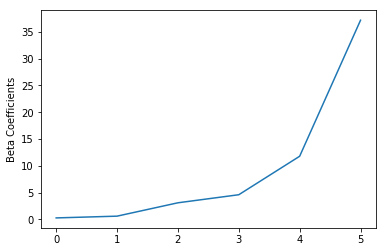

In [21]:
import matplotlib.pyplot as plt
import numpy as np

beta=np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

In [18]:
# Print the coefficients and intercept for linear regression.
print("Coefficients: {} Intercept: {}".format(lrModel.coefficients,lrModel.intercept))

Coefficients: [0.5865445359576769,5.135295766299486,0.2651315083346176,37.56813939056708,2.9806662321969695,11.652174787698247] Intercept: -76.76493296591603


In [19]:
# Let's evaluate the model against the test data.
test_results = lrModel.evaluate(test_data)

In [26]:
# Interesting results! This shows the difference between the predicted value and the test data.
test_results.residuals.show()

# Let's get some evaluation metrics (as discussed in the previous linear regression notebook).
print("RSME_Ridge: {}".format(test_results.rootMeanSquaredError))

+-------------------+
|          residuals|
+-------------------+
|  58.85144045775292|
|  58.85144045775292|
|  50.05327241838777|
|  44.36882359927051|
|  36.84174007765073|
|  34.80311448348817|
| 27.193678421184735|
| 23.895442457502092|
| 14.553047711258998|
|   5.47588768560432|
|   5.47588768560432|
|-3.9088248897185025|
|-3.9088248897185025|
|-3.9088248897185025|
|-3.9088248897185025|
|  5.491530590750699|
| -0.960459304783754|
|  -42.5704500109516|
|-169.11890501962023|
|-239.74610144432341|
+-------------------+
only showing top 20 rows

RSME_Ridge: 446.9199748604489


In [21]:
# We can also get the R2 value. 
print("R2_Ridge: {}".format(test_results.r2))

R2_Ridge: 0.7085284109030074


In [22]:
final_data.describe().show()

+-------+------------------+
|summary|           Profits|
+-------+------------------+
|  count|             40285|
|   mean|234.69782905826548|
| stddev| 914.4112274804912|
|    min|           -130.02|
|    max|           38656.0|
+-------+------------------+



In [33]:
results_w_columns=lrModel.transform(test_data)

In [36]:
results_w_columns.dtypes

[('features', 'vector'), ('Profits', 'double'), ('prediction', 'double')]

In [38]:
results_w_columns.toPandas()

,features,Profits,prediction
0,"(2.0, 0.0, 63.14, 0.0, 0.0, 0.0)",0.00,-58.851440
1,"(2.0, 0.0, 63.14, 0.0, 0.0, 0.0)",0.00,-58.851440
2,"(17.0, 0.0, 63.14, 0.0, 0.0, 0.0)",0.00,-50.053272
3,"(39.0, 0.0, 35.91, 0.0, 0.0, 0.0)",0.00,-44.368824
4,"(39.0, 0.0, 64.3, 0.0, 0.0, 0.0)",0.00,-36.841740
5,"(43.0, 0.0, 63.14, 0.0, 0.0, 0.0)",0.00,-34.803114
6,"(74.0, 0.0, 23.26, 0.0, 0.0, 0.0)",0.00,-27.193678
7,"(74.0, 0.0, 35.7, 0.0, 0.0, 0.0)",0.00,-23.895442
8,"(77.0, 0.0, 64.3, 0.0, 0.0, 0.0)",0.00,-14.553048
9,"(93.0, 0.0, 63.14, 0.0, 0.0, 0.0)",0.00,-5.475888


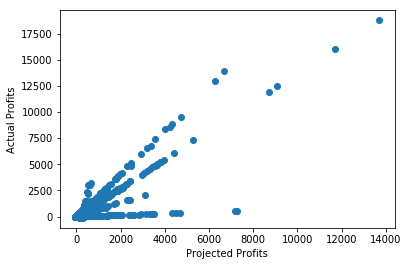

In [40]:
import matplotlib.pyplot as plt
plt.scatter(x=results_w_columns.toPandas()['prediction'],y=results_w_columns.toPandas()['Profits'])
plt.xlabel('Projected Profits')
plt.ylabel('Actual Profits')
plt.show()